In [4]:
import pandas as pd
import seaborn as sns
from nltk.sentiment.vader import SentimentIntensityAnalyzer

## Sentiment Analysis with VADER

### Key Terms

* Lexicon: A lexicon is a list of word mapped to a sentiment or emotion.  In the simplest case, positive vs. negative.
    + Difficult and time consuming to create (usually by lots of human reviewers)
    + Example: (LIWC (Linguistic Inquiry and Word Count))[https://www.liwc.app/]
* Valence: A scoring of direction and intensity (e.g. "wonderful" vs "alright")

### VADER

[VADER paper](https://ojs.aaai.org/index.php/ICWSM/article/view/14550)

VADER (Valence  Aware  Dictionary  for sEntiment Reasoning) uses a valence lexicon (derived from previous work with crowdsourced additions) with a few rule-based modifiers (see the paper for more details).  

1. Punctuation, especially !
2. Capitalization
3. Degree modifiers (i.e. adverbs)
4. "But"...
5. Negation

VADER was specifically created for social media posts and was tested against tweets, movie reviews, technical reviews, and opinion news articles.

VADER is free and available as a module in NLTK.

In [56]:
#import nltk
#nltk.download('vader_lexicon')
sid = SentimentIntensityAnalyzer()

#### VADER Lexicon

Let's look at a few words in the VADER lexicon.

Scores range from -4 (most negative) to +4 (most positive).

In [9]:
len(sid.lexicon) #How many words does the lexicon cover?

7502

In [3]:
sid.lexicon[":("]

-1.9

In [4]:
sid.lexicon[":)"]

2.0

#### Rule-based modifiers

Here's a simple example of how the rule based modifiers can change the overall sentiment.  Let's look at the word "good" in the lexicon.

In [51]:
sid.lexicon["good"]

1.9

The `polarity_scores` method provides four different values:
* `neg` (negative), `neu` (neutral), and `pos` (positive) are standardized scores from 0 to 1 that add up to 1.
* `compound` is a normalized score that places the entire text on a -1 to 1 negative to positive scale

In [54]:
sid.polarity_scores("good")

{'neg': 0.0, 'neu': 0.0, 'pos': 1.0, 'compound': 0.4404}

Adding "that was" increases the neutrality, but doesn't change the overall score.

In [55]:
sid.polarity_scores("that was good")

{'neg': 0.0, 'neu': 0.408, 'pos': 0.592, 'compound': 0.4404}

Now let's explore the effects of some modifiers!

In [53]:
sid.polarity_scores("that was good!")

{'neg': 0.0, 'neu': 0.385, 'pos': 0.615, 'compound': 0.4926}

In [47]:
input_text = ["that was good", "that was GOOD" ,"that was good!", "that was good!!", 
              "that was good!!!", "that was extremely good", "that was good, but not great"]
pd.DataFrame([{'input':text} | sid.polarity_scores(text) for text in input_text])

,input,neg,neu,pos,compound
0,that was good,0.000,0.408,0.592,0.4404
1,that was GOOD,0.000,0.355,0.645,0.5622
2,that was good!,0.000,0.385,0.615,0.4926
3,that was good!!,0.000,0.365,0.635,0.5399
4,that was good!!!,0.000,0.346,0.654,0.5826
5,that was extremely good,0.000,0.484,0.516,0.4927
6,"that was good, but not great",0.427,0.385,0.188,-0.5409


### VADER Example: Reddit books data

The following were the top 100 posts alongside their comments from the books subreddit on February 14, 2024.  These were pulled using the `praw` library, similarly to previous reddit data.

In [65]:
df = pd.read_csv("reddit_books.csv", encoding='utf-8')
df.sample(3)

,id,author,created,title,content,subreddit,url,num_comments,score,upvote_ratio,comments,comments_text,comment_blob
39,1apfsnm,Nolls-97,2024-02-13 00:27:56+00:00,Favorite Thomas Harris novel? (Spoilers for th...,What is your favorite Thomas Harris novel and ...,books,https://www.reddit.com/r/books/comments/1apfsn...,32,26,0.85,<praw.models.comment_forest.CommentForest obje...,"['red dragon, hands down.', 'I still think abo...","red dragon, hands down. | I still think about ..."
32,1apcggc,Dry_Lynx5282,2024-02-12 22:04:15+00:00,Little Women and Alcott's original intent,As someone who has read Little Women only two ...,books,https://www.reddit.com/r/books/comments/1apcgg...,60,113,0.82,<praw.models.comment_forest.CommentForest obje...,"['A direct quote from Alcott: ""“[S]o many ent...","A direct quote from Alcott: ""“[S]o many enthu..."
27,1aqiclr,2_cute_2_poot,2024-02-14 08:43:34+00:00,How to break in a fancy hardcover?,"Hi, I’m usually pretty chill with letting book...",books,https://www.reddit.com/r/books/comments/1aqicl...,9,0,0.40,<praw.models.comment_forest.CommentForest obje...,"[""Tbh, I always take great care not to crease ...","Tbh, I always take great care not to crease th..."


Let's pull polarity scores for both the post content and the comments (all together).

In [69]:
def vader_scores(text):
    try:
        return sid.polarity_scores(text)
    except:
        return dict()

comments_vader = df.comment_blob.apply(vader_scores).apply(pd.Series).add_prefix("comm_")
post_vader = df.content.apply(vader_scores).apply(pd.Series).add_prefix("post_")
scores = pd.concat([df, post_vader,comments_vader], axis = 1)

In [70]:
scores.sample(5)

,id,author,created,title,content,subreddit,url,num_comments,score,upvote_ratio,...,comments_text,comment_blob,post_neg,post_neu,post_pos,post_compound,comm_neg,comm_neu,comm_pos,comm_compound
96,1anqcyu,PunyParker826,2024-02-10 21:03:39+00:00,The Three-Body Problem is excellent… but know ...,Just finished Cixin Liu’s excellent sci-fi nov...,books,https://www.reddit.com/r/books/comments/1anqcy...,62,66,0.70,...,['Spoilers below:\n\nI actually liked that ang...,Spoilers below:\n\nI actually liked that angle...,0.043,0.815,0.142,0.9855,0.061,0.761,0.177,0.9999
76,1aoxgfr,Reddit_Books,2024-02-12 11:00:22+00:00,"Weekly Calendar - February 12, 2024","Hello readers!\n\nEvery Monday, we will post a...",books,https://www.reddit.com/r/books/comments/1aoxgf...,1,0,0.50,...,['Could you suggest a book that aligns with my...,Could you suggest a book that aligns with my t...,0.000,1.000,0.000,0.0000,0.051,0.793,0.156,0.9318
98,1aosi9o,PrestigiousLet9244,2024-02-12 05:26:29+00:00,Shoe dog,People recommend shoe dog so I bought it and s...,books,https://www.reddit.com/r/books/comments/1aosi9...,11,0,0.22,...,['There are so many errors here; I don’t know ...,There are so many errors here; I don’t know wh...,0.197,0.741,0.062,-0.8706,0.124,0.742,0.134,0.2174
16,1appe10,eleven_paws,2024-02-13 09:18:19+00:00,Favorite and least favorite reads of the year ...,This can be anything you’ve finished in 2024 (...,books,https://www.reddit.com/r/books/comments/1appe1...,609,205,0.91,...,['Favorite: We Have Always Lived in the Castle...,Favorite: We Have Always Lived in the Castle b...,0.022,0.837,0.142,0.8715,0.112,0.670,0.217,1.0000
39,1apfsnm,Nolls-97,2024-02-13 00:27:56+00:00,Favorite Thomas Harris novel? (Spoilers for th...,What is your favorite Thomas Harris novel and ...,books,https://www.reddit.com/r/books/comments/1apfsn...,32,26,0.85,...,"['red dragon, hands down.', 'I still think abo...","red dragon, hands down. | I still think about ...",0.020,0.686,0.294,0.9760,0.111,0.702,0.187,0.9985


In [82]:
scores.sort_values("post_compound", ascending=True).url.tolist()[0]

'https://www.reddit.com/r/books/comments/1aqhuga/tw_sexual_assault_talk_my_rant_to_people_who_hate/'

What post has the most positive content (via the `pos` score)?

In [74]:
scores.sort_values("post_pos", ascending=False, ignore_index=True).content[0]

'Im currently reading Gormenghast trilogy, and i feel warm, i feel interested, devoted to book, it feels soft, yet punchy when it desires to, and leaves with no choice but to think. It awakes certain sense of caring for the characters, where everything that Peake wrote fights against simple knowing what will happen, but living in the moment with characters and daring to think what will be. Peake-s writing is something special and truly a gem, he literally writes as he paints a painting, sweet and sour :) Interesting thing is last book i read before starting Gormenghast was Clockwork Orange, Anthony Burgess and Michael Moorcock (aside from Elric, Hawkmoon would be my favorite ever) were pretty vocal of Gormenghast and Peake as an outstanding work of pure lovely genious, and writing that screams word amazement. Well i guess this is appreciation post :) Cheers Gormenghasters!'

The most negative?

In [73]:
scores.sort_values("post_compound", ascending=True, ignore_index=True).content[0]

'For context, I am a 23 year old woman who was raped a few years ago after a man took me to his home while I was in an drunken unconscious state. I awoke just towards the end and immediately left and walked home, trying to comprehend if that had really just happened. It did and I have since recovered mentally and emotionally so please, your heartfelt sorry\'s, while appreciated, are not necessary :)  \nSo, I\'m sick of people labelling books as bad only because it includes sexual assault in the narrative. Especially when said people go on a rant about why they think the book is bad because of it. They say how it doesn\'t describe the act of assault accurately to real life. They say it shouldn\'t be included at all because media is supposed to be escapism. They say it\'s overdone.  \nRape is different for every single victim. There are SO MANY variables and types. Some victims black out. Some are hyper aware. And some even orgasm. The only commonality to occur is, by the end, we are rid

The most neutral?

In [14]:
scores.sort_values("post_neu", ascending=False, ignore_index=True).content[0]

"Hello readers!\n\nEvery Monday, we will post a calendar with the date and topic of that week's threads and we will update it to include links as those threads go live.  All times are Eastern US.\n\n---\n\nDay|Date|Time(ET)|Topic|\n-|-|-|-\n^Monday|^(February 12)||[^(What are you Reading?)](https://redd.it/1aoxg9o)\n^Tuesday|^(February 13)||[^(Simple Questions)](https://redd.it/1appyam)\n^Wednesday|^(February 14)||^(LOTW)\n^Thursday|^(February 15)||^(Favorite Books)\n^Friday|^(February 16)||^(Weekly Recommendation Thread)\n^Saturday|^(February 17)||^(Simple Questions)\n^Sunday|^(February 18)||^(Weekly FAQ: What do you use as a bookmark?)"

<Axes: xlabel='post_pos', ylabel='comm_pos'>

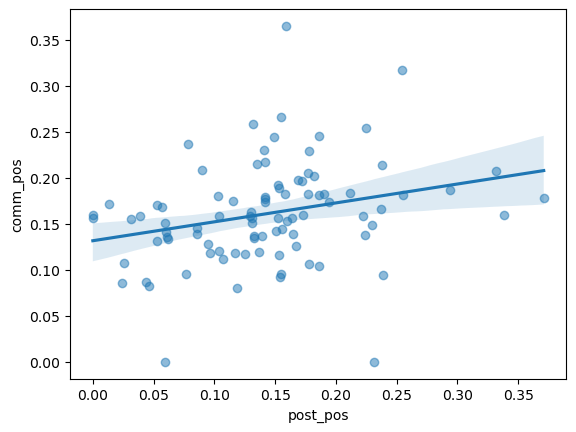

In [89]:
sns.regplot(data = scores, x="post_pos", y = "comm_pos", scatter_kws = {"alpha":0.5})

<Axes: xlabel='post_neu', ylabel='num_comments'>

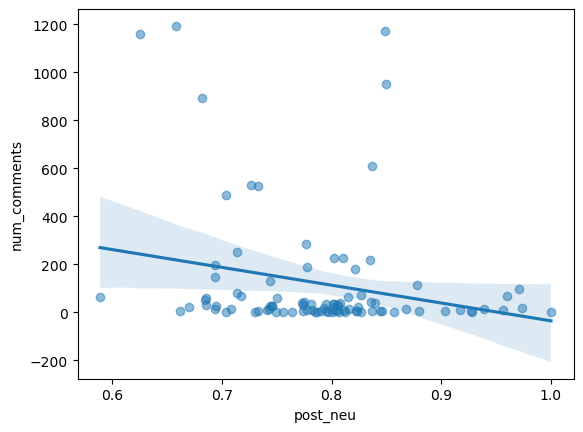

In [16]:
sns.regplot(data = scores, x="post_neu", y = "num_comments", scatter_kws = {"alpha":0.5})

<Axes: xlabel='post_neu', ylabel='upvote_ratio'>

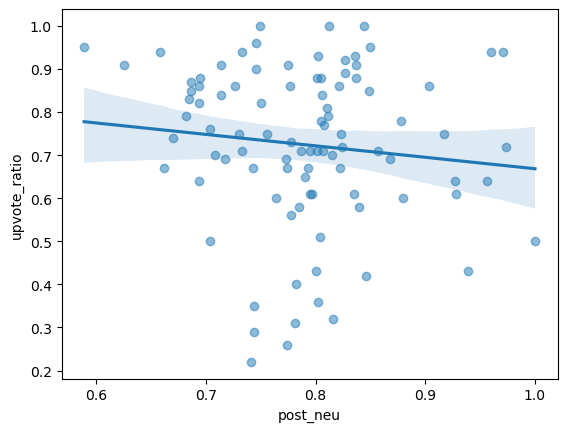

In [17]:
sns.regplot(data = scores, x="post_neu", y = "upvote_ratio", scatter_kws = {"alpha":0.5})

<Axes: xlabel='post_pos', ylabel='comm_pos'>

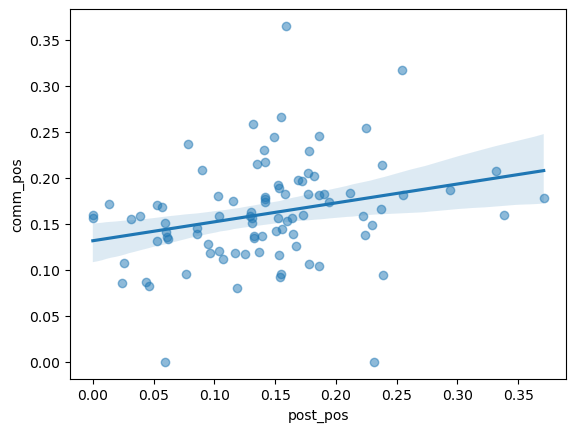

In [18]:
sns.regplot(data = scores, x="post_pos", y = "comm_pos", scatter_kws = {"alpha":0.5})

## Topic Modeling

Basic topics
Adjusting k
Custom stop words
Correlation between topics, relating topics to reddit data

In [21]:
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer

First, we'll create a dataframe of all of our text, both posts and comments, together to get a bigger universe for our models.

In [22]:
import ast
df["comments_list"] = df.comments_text.apply(ast.literal_eval)
exploded = df[["comments_list"]].explode("comments_list", ignore_index=True)
exploded["type"] = "comment"
exploded.rename(columns = {"comments_list":"text"}, inplace=True)
posts_df = df[["content"]].copy()
posts_df["type"] = "post"
posts_df.rename(columns = {"content":"text"}, inplace=True)
main = pd.concat([posts_df, exploded], axis = 0).reset_index()
main = main.loc[main.text.notnull(),:]

Just like in previous weeks, we'll use a vectorizer from scikit-learn to split our text into tokens, remove stopwords and very frequent / infrequent terms.  We'll start with a simple CountVectorizer.

In [44]:
vectorizer = CountVectorizer(min_df = 0.01, max_df = 0.5, stop_words = 'english')

vectors = vectorizer.fit_transform(main.text)

In [80]:
num_topics = 8

lda = LatentDirichletAllocation(
    n_components=num_topics,
    learning_method = "online",
    random_state = 2342,
    n_jobs = 4
)
lda_results = lda.fit_transform(vectors) 

In [81]:
terms = vectorizer.get_feature_names_out()

for index, component in enumerate(lda.components_):
    zipped = zip(terms, component)
    top_terms_key=sorted(zipped, key = lambda t: t[1], reverse=True)[:10]
    top_terms_list=list(dict(top_terms_key).keys())
    print("Topic "+str(index+1)+": ",top_terms_list)

Topic 1:  ['read', 'time', 'don', 'years', 'know', 'want', 'ago', 'kids', 'old', 'pages']
Topic 2:  ['read', 'book', 'just', 've', 'reading', 'finished', 'really', 'lol', 'started', 'story']
Topic 3:  ['loved', 'good', 'absolutely', 'novels', 'stories', 'kid', 'oh', 'right', 'list', 'recommend']
Topic 4:  ['books', 'book', 'read', 'like', 'work', 'reading', 've', 'used', 'new', 'just']
Topic 5:  ['great', 'did', 'man', 'book', 'way', 'couldn', 'written', 'left', 'beautiful', 'writer']
Topic 6:  ['book', 'favorite', 'series', 'love', 'read', 'king', 'ending', 'really', 'haven', 'liked']
Topic 7:  ['books', 'book', 'school', 'think', 'read', 'help', 'self', 'fiction', 'literature', 'high']
Topic 8:  ['like', 'people', 'just', 'think', 'don', 'book', 'way', 'really', 'things', 'didn']


In [82]:
lda_res_df = pd.DataFrame(lda_results, columns = ["Topic_"+str(k) for k in range(1,(num_topics+1))])
lda_res_df["MainTopic"] = lda_res_df.idxmax(axis = 1)

In [83]:
lda_df = pd.concat([main, lda_res_df], axis = 1)

In [84]:
pd.crosstab(lda_df.type, lda_df.MainTopic, normalize = "index")

MainTopic,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Topic_6,Topic_7,Topic_8
type,,,,,,,,
comment,0.122716,0.148971,0.026949,0.154985,0.034698,0.12607,0.111381,0.274231
post,0.042553,0.159574,0.000000,0.191489,0.021277,0.06383,0.117021,0.404255


#### Visualizing Topics with pyLDAvis

In [85]:
import pyLDAvis
import pyLDAvis.lda_model
pyLDAvis.enable_notebook()
pyLDAvis.lda_model.prepare(lda, vectors, vectorizer)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
7     -0.100713  0.019080       1        1  29.796953
3     -0.110578 -0.043859       2        1  15.741436
6     -0.104101  0.017118       3        1  13.865544
1     -0.082171 -0.008646       4        1  13.466857
5     -0.040202  0.004960       5        1  10.236964
0     -0.097243 -0.209420       6        1   6.918451
4      0.107701  0.364064       7        1   5.194672
2      0.427306 -0.143297       8        1   4.779125, topic_info=        Term         Freq        Total Category  logprob  loglift
195     read  3241.000000  3241.000000  Default  30.0000  30.0000
248     time  1185.000000  1185.000000  Default  29.0000  29.0000
60       don  1258.000000  1258.000000  Default  28.0000  28.0000
28     books  2535.000000  2535.000000  Default  27.0000  27.0000
27      book  3368.000000  3368.000000  Default  26.0000  26.0000
..       ...          ...          ...      ...      ...      ...
153     love   102.903570   743.821149   Topic8  -3.6026   1.0629
198  reading   106.078181  1202.969737   Topic8  -3.5722   0.6125
49      dark    12.892220   216.388457   Topic8  -5.6797   0.2205
55      didn    29.124132   565.310552   Topic8  -4.8648   0.0751
195     read    28.315921  3241.773643   Topic8  -4.8929  -1.6995

[345 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
0         2  0.991758          10
2         2  0.989550          30
3         1  0.845839        able
3         3  0.149648        able
4         5  0.060004  absolutely
...     ...       ...         ...
285       3  0.743646         yes
286       1  0.262854       young
286       2  0.023896       young
286       3  0.326576       young
286       4  0.374367       young

[699 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[8, 4, 7, 2, 6, 1, 5, 3])